In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pymc3 as pm
from scipy import stats

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [856]:
w0 = 0.125
b0 = 5.
x_range = [-20, 60]

def load_dataset(n=300, n_tst=150):
    np.random.seed(43)
    def s(x):
        g = (x - x_range[0]) / (x_range[1] - x_range[0])
        return 3 * (0.25 + g**2.)
    x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
    eps = np.random.randn(n) * s(x)
    y = (w0 * x * (1. + np.sin(x)) + b0) + eps
    x = x[..., np.newaxis]
    x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32)
    x_tst = x_tst[..., np.newaxis]
    return y, x, x_tst

y, x, x_tst = load_dataset()

In [857]:
ssx = MinMaxScaler()#StandardScaler()
x = ssx.fit_transform(x)

ssy = MinMaxScaler()#StandardScaler()
y = ssy.fit_transform(y.reshape(-1, 1))

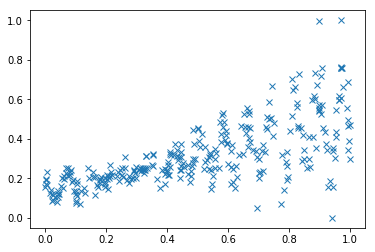

In [858]:
plt.plot(x, y, 'x')

Customized, but somehow doesn't work and makes model very slow...

In [801]:
# np.random.seed(1)

# w0 = .2
# b0 = .25
# x_range = [-.5, 1]

# def load_dataset(n=150, n_tst=150):
#     def s(x):
#         g = (x - x_range[0]) / (x_range[1] - x_range[0]) / 2.5
#         return .05 + g**2
    
#     x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
#     eps = np.random.randn(n) * s(x) 
#     y = (w0 * x * (1. + np.sin(x)) + b0) + eps
#     x = x[..., np.newaxis]
#     x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32)
#     x_tst = x_tst[..., np.newaxis]
#     return y, x, x_tst

# y, x, x_tst = load_dataset()

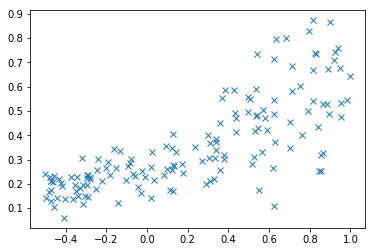

In [802]:
# plt.plot(x, y, 'x')

## The Bayesian approach

**Priors**:

$\alpha \sim N(0, 1)$

$\beta \sim N(0,1)$

Linear Regression: $\mu = \alpha + \beta x$

**(Extra) Increasing variance**:

$softplus(x) = \ln(1+e^x) $

$\sigma = 1e^{-5} + softplus(x)$

**Likelihood**: 

$y \sim N(\mu, \sigma)$



As you can see on the plot, the variance increases when x increases. Therefore I model the variance as a softplus method.

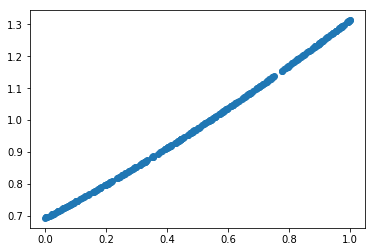

In [859]:
def softplus(x):
    return np.log(1 + np.exp(x))

plt.plot(x, softplus(x), 'o')

Modelling this linear regression with increasing variance. 

In [860]:
np.log(np.expm1(1.)), 1e-1

(0.541324854612918, 0.1)

In [861]:
# c = np.log(np.expm1(1.))
with pm.Model():
    alpha = pm.Normal('alpha', 0, 10)
    beta = pm.Normal('beta', 0, 10)
    mu = alpha + beta * x
#     sd = pm.Deterministic('sigma', 1e-5 + pm.math.log1pexp(1e-5 * mu))
    sd_offset = pm.Normal('sd_offset', mu=0, sd=10)
    sd_scale = pm.Normal('sd_scale', mu=0, sd=10)
    sd_reg = pm.HalfNormal('sd_reg', sd=10)
    sd = pm.Deterministic('sigma', sd_reg + pm.math.log1pexp(mu * sd_scale + sd_offset))

    obs = pm.Normal('obs', mu, sd=sd, observed=y)
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd_reg, sd_scale, sd_offset, beta, alpha]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:19<00:00, 504.71draws/s]
The acceptance probability does not match the target. It is 0.8890153856612907, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9022450153176722, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


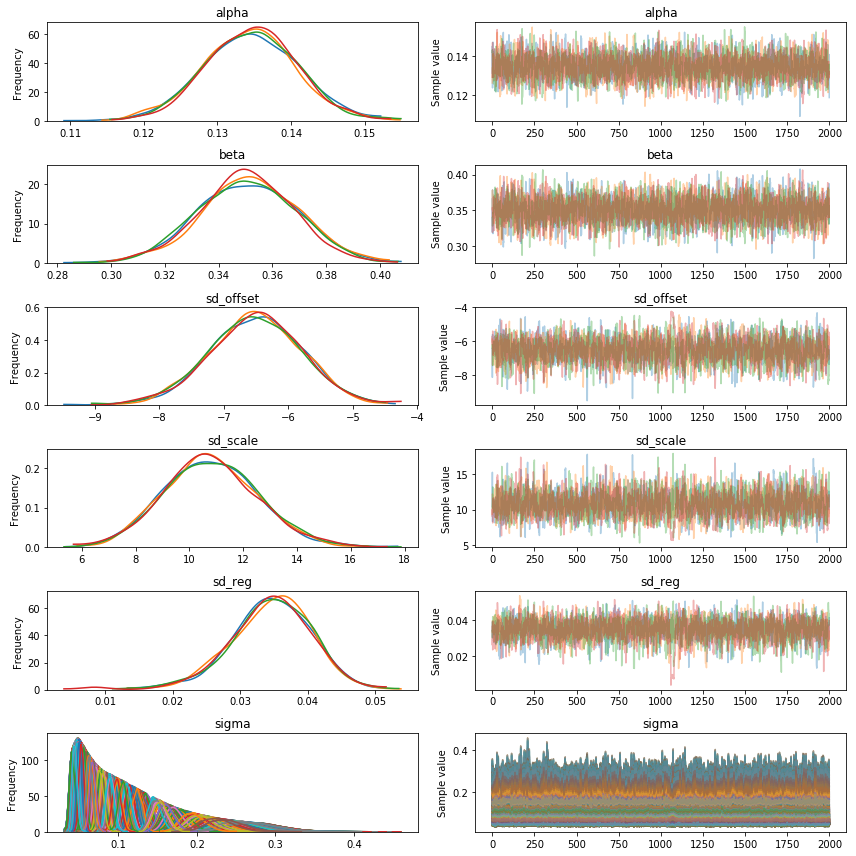

In [862]:
pm.traceplot(trace);

In [863]:
x_ = np.sort(x, axis=0)
mu = (trace['alpha'] + trace['beta'] * x_)
# sigma = 1e-5 + softplus(x_ * trace['sd_scale'] + trace['sd_offset'])
# sigma = 1e-10 + softplus(x_ * mu)
sigma = np.sort(np.transpose(np.squeeze(trace['sigma'], axis=-1)), axis=0)
std_2_plus = mu + 2 * sigma
std_2_min = mu - 2 * sigma

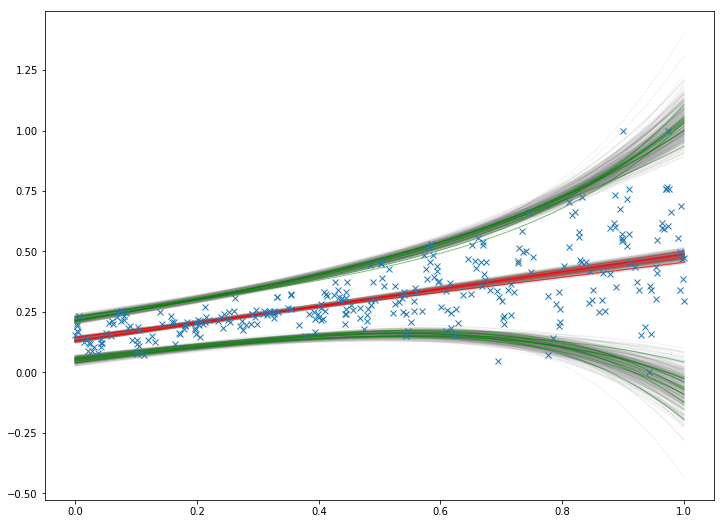

In [864]:
plt.figure(figsize=(12, 9))
n = 300
n_c = 10

plt.plot(x_, (trace['alpha'][:n] + trace['beta'][:n] * x_), alpha=.1, lw=1, c='grey')
plt.plot(x_, std_2_min[:, :n], alpha=.1, lw=1, c='grey')
plt.plot(x_, std_2_plus[:, :n], alpha=.1, lw=1, c='grey')
plt.plot(x_, (trace['alpha'][n:n+n_c] + trace['beta'][n:n+n_c] * x_), alpha=.5, lw=1, c='red')
plt.plot(x_, std_2_min[:, n:n+n_c], alpha=.5, lw=1, c='green')
plt.plot(x_, std_2_plus[:, n:n+n_c], alpha=.5, lw=1, c='green')

plt.plot(x, y, 'x');

## Pytorch quantile regression

In [5]:
import torch
from torch import nn

In [6]:
class QuantileLoss(nn.Module):
    def __init__(self, quantiles):
        super().__init__()
        self.quantiles = quantiles

    def forward(self, preds, target):
        assert not target.requires_grad
        assert preds.size(0) == target.size(0)
        assert preds.size(1) == 1
        
        def _tilted_loss(q, e):
            return torch.max((q-1) * errors, q * e).unsqueeze(1)
        
        err = target - preds
        losses = [_tilted_loss(q, err[:, i])  # calculate per quantile
                  for q in enumerate(quantiles)]
            
        loss = torch.mean(torch.sum(torch.cat(losses, dim=1), dim=1))
        return loss

In [101]:
class DeepQuantileRegression(nn.Module):
    def __init__(self, quantiles):
        super().__init__()
        self.quantiles = quantiles
        self.model = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, len(quantiles))
        )
    
    def forward(self, X):
        return self.model(X)


In [131]:
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

In [134]:
QS = np.linspace(0.05,0.95,11)

m = DeepQuantileRegression(quantiles=QS)
criterion = QuantileLoss(QS)
optim = torch.optim.Adam(m.parameters())

train_ds = TensorDataset(torch.tensor(x))
train_dl = DataLoader(train_ds, 32, shuffle=True)

In [142]:
m = m.train()
for batch in train_dl:
    print(batch[0])
    optim.zero_grad()
    preds = m(batch[0])
    loss = criterion(preds, y)
    loss.backward()
    optim.step()

<class 'torch.Tensor'>


RuntimeError: Expected object of scalar type Float but got scalar type Double for argument #4 'mat1'

In [27]:
a = torch.tensor([[1,2,3]]).view(-1,1)
b = torch.tensor([[2,3,2], [4, 5, 4], [9,9,8]]).view(3,3)
a.size(0), b.size(0)

(3, 3)

In [26]:
(a - b)

tensor([[-1, -2, -1],
        [-2, -3, -2],
        [-6, -6, -5]])